# Merging EB terms-  NLS -  Encyclopaedia Britannica


### Loading the necessary libraries

In [2]:
import yaml
import matplotlib.pyplot as plt
import numpy as np
import collections
import matplotlib as mpl

In [3]:
import pandas as pd
from yaml import safe_load
from pandas.io.json import json_normalize

### Functions

In [4]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    return query_results


In [5]:
def write_query_results(filename, results):
    with open('./results_NLS/'+filename, 'w') as f:
        documents = yaml.dump(results, f)

In [18]:
def create_dataframe(query_results):
    for edition in query_results:
        for page in query_results[edition]:
            #print(page[1].keys())
            column_list=list(page[1].keys())
            break
        break
        
    data=[]
    for edition in query_results:
        for page in query_results[edition]:
            try:
                data.append(page[1])
               
            except:
                pass
    df = pd.DataFrame(data, columns = column_list)
    #removing the columns that I dont need 
    df= df.drop(['last_term_in_page', 'model', 'num_articles', 'num_page_words', 'num_text_unit' , 'text_unit'], axis=1)
    return df

In [19]:
def create_dataframe_from_file(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = safe_load(f)
    
    df = create_dataframe(query_results)
    return df

In [256]:
def prune_json(json_dict):
    """
    Method that given a JSON object, removes all its empty fields.
    This method simplifies the resultant JSON.
    :param json_dict input JSON file to prune
    :return JSON file removing empty values
    """
    final_dict = {}
    if not (isinstance(json_dict, dict)):
        # Ensure the element provided is a dict
        return json_dict
    else:
        for a, b in json_dict.items():
            if b or isinstance(b, bool):
                if isinstance(b, dict):
                    aux_dict = prune_json(b)
                    if aux_dict:  # Remove empty dicts
                        final_dict[a] = aux_dict
                elif isinstance(b, list):
                    aux_list = list(filter(None, [prune_json(i) for i in b]))
                    if len(aux_list) > 0:  # Remove empty lists
                        final_dict[a] = aux_list
                else:
                    final_dict[a] = b
    return final_dict

In [257]:
def merge_terms(query_results):
    eliminate_pages={}
    for edition in query_results:
        eliminate_pages[edition]=[]
        page_number_dict={}
        for page_idx in range(0, len(query_results[edition])):
            
            current_page=query_results[edition][page_idx][0]
            if current_page not in page_number_dict:
                page_number_dict[current_page]=page_idx
        
            element = query_results[edition][page_idx][1]
            if "previous_page" in element['term']:
                current_definition= element["definition"]
                previous_page_idx= page_idx -1
                previous_page_number = current_page -1
                num_article_words=element["num_article_words"]
                related_terms=element["related_terms"]
                
                
                prev_elements = query_results[edition][previous_page_idx][1]
                if prev_elements["last_term_in_page"]:
                   
                    prev_elements["definition"]+=current_definition
                    prev_elements["num_article_words"]+=num_article_words
                    prev_elements["related_terms"]+= related_terms
                    prev_number = int(prev_elements['text_unit_id'].split("Page")[1])
                    
                    for prev_articles_idx in range(page_number_dict[prev_number], page_idx):
                       
                        if query_results[edition][prev_articles_idx][0] == prev_number:
                           
                            query_results[edition][prev_articles_idx][1]["num_page_words"]+=num_article_words
                    
                  
                    for update_element_idx in range(page_number_dict[current_page], page_idx+1):
                        if query_results[edition][update_element_idx][0] == current_page:
                            query_results[edition][update_element_idx][1]["num_page_words"]-=num_article_words
                            query_results[edition][update_element_idx][1]["num_articles"]-=1
                    
                
                eliminate_pages[edition].append(page_idx)
              
   
    
    return query_results, eliminate_pages

In [258]:
def delete_entries(query_results_updated):
    new_results={}
    for edition in query_results_updated:
        new_results[edition]=[]
        for page_idx in range(0, len(query_results_updated[edition])):
            if page_idx not in eliminate_pages[edition]:
                new_results[edition].append(query_results_updated[edition][page_idx])
    return new_results

In [259]:
query_results=read_query_results('results_eb_first_volume1')

In [260]:
query_results_updated, eliminate_pages=merge_terms(query_results)

In [261]:
new_results=delete_entries(query_results_updated)            

In [192]:
#prune_results=prune_json(query_results_updated)

In [263]:
write_query_results("results_eb_first_volume1_updated", new_results)

In [20]:
df=create_dataframe_from_file("results_eb_first_volume1_updated")

In [21]:
#df=create_dataframe(new_results)

In [22]:
df.head()

,archive_filename,definition,edition,header,num_article_words,place,related_terms,source_text_file,term,term_id_in_page,text_unit_id,title,type_archive,type_page,year
0,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,n*s-f 7^' v L i A j J ^ /^^W / ; H:;^’ J }r-r£...,"First edition, 1771, Volume 1, A-B",iiiubnsfvnsfv,58,Edinburgh,[],alto/188082735.34.xml,iiiubnsfvnsfv,0,Page2,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
1,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,S :u -I >;J .1 M U a C V',"First edition, 1771, Volume 1, A-B",**■*,10,Edinburgh,[],alto/188082813.34.xml,first_article,0,Page8,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
2,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,COVI PILED UPON A NEW PLAN. IN WHICH The difer...,"First edition, 1771, Volume 1, A-B",FrontPage,91,Edinburgh,[],alto/188082826.34.xml,FrontPage,0,Page9,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
3,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,UTILITY ought to be the principal intention of...,"First edition, 1771, Volume 1, A-B",Preface,363,Edinburgh,[],alto/188082852.34.xml,Preface,0,Page11,"Encyclopaedia Britannica; or, A dictionary of ...",book,FullPage,1771
4,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"TH E Editors, though fully fen&ble of the prop...","First edition, 1771, Volume 1, A-B",viPREFACE,410,Edinburgh,[],alto/188082865.34.xml,viPREFACE,0,Page12,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771


In [23]:
df.iloc[0]

archive_filename     /Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...
definition           n*s-f 7^' v L i A j J ^ /^^W / ; H:;^’ J }r-r£...
edition                             First edition, 1771, Volume 1, A-B
header                                                   iiiubnsfvnsfv
num_article_words                                                   58
place                                                        Edinburgh
related_terms                                                       []
source_text_file                                 alto/188082735.34.xml
term                                                     iiiubnsfvnsfv
term_id_in_page                                                      0
text_unit_id                                                     Page2
title                Encyclopaedia Britannica; or, A dictionary of ...
type_archive                                                      book
type_page                                                     FullPage
year  

In [25]:
df_related=df[df['related_terms'].apply(lambda x: len(x)) > 0]

In [26]:
df_related=df_related.explode('related_terms')

In [27]:
df_related

,archive_filename,definition,edition,header,num_article_words,place,related_terms,source_text_file,term,term_id_in_page,text_unit_id,title,type_archive,type_page,year
19,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in ichthyology, a barbarous name of the zeus v...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,19,Edinburgh,ZEUS,alto/188082904.34.xml,ABACATUAIA,12,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
20,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"AY, a barbarous name of a species of the pfitt...","First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,14,Edinburgh,PSITTACUS,alto/188082904.34.xml,ABAC,13,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
22,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABACUS.,"First edition, 1771, Volume 1, A-B",EncyclopaediaBritannica,2,Edinburgh,ABACUS,alto/188082904.34.xml,ABACISCUS,15,Page15,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
36,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"in botany, a fynonime of the calycanthus prtec...","First edition, 1771, Volume 1, A-B",ABAABB,22,Edinburgh,CALYCANTHUS,alto/188082917.34.xml,ABAI,8,Page16,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
37,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,See ABASED.,"First edition, 1771, Volume 1, A-B",ABAABB,2,Edinburgh,ABASED,alto/188082917.34.xml,ABAISSE,9,Page16,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"Ji-ole for a night together, that the (leant o...","First edition, 1771, Volume 1, A-B",BREWING,1677,Edinburgh,ANCON,alto/188093203.34.xml,BREWING,0,Page807,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771
3961,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"Ji-ole for a night together, that the (leant o...","First edition, 1771, Volume 1, A-B",BREWING,1677,Edinburgh,BRIAR,alto/188093203.34.xml,BREWING,0,Page807,"Encyclopaedia Britannica; or, A dictionary of ...",book,Topic,1771
4124,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"a port-town of Egypt, situated on the western ...","First edition, 1771, Volume 1, A-B",BUFBUI,52,Edinburgh,BUGLOSS,alto/188093359.34.xml,BUGIE,21,Page819,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771
4142,/Users/rosafilgueira/HW-Work/NLS-Fellowship/wo...,"an iron or leaden ball, pr ftiot, wherewith fi...","First edition, 1771, Volume 1, A-B",BULBUN,18,Edinburgh,BULLINGBROKE,alto/188093385.34.xml,BULLET,3,Page821,"Encyclopaedia Britannica; or, A dictionary of ...",book,Articles,1771


In [28]:
import networkx as nx
graph_df = nx.from_pandas_edgelist(df_related, source='term', target='related_terms', edge_attr=True)

In [29]:
graph_df

/anaconda3/envs/mypython3/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/envs/mypython3/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


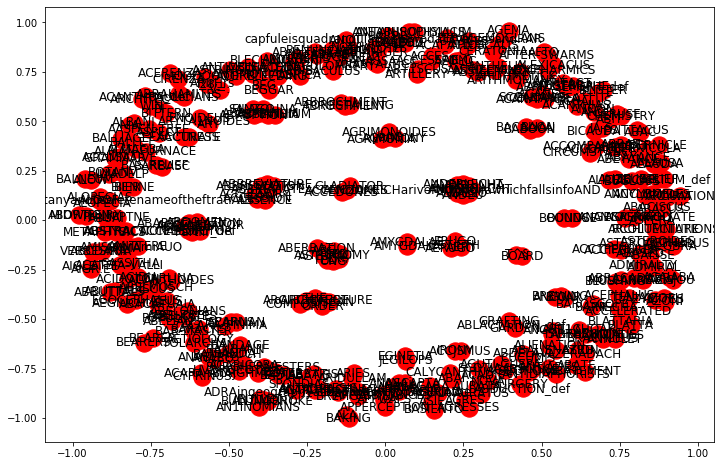

In [30]:
import matplotlib.pyplot as plt
#matplotlib inline

plt.figure(figsize=(12,8))
nx.draw_networkx(graph_df, with_labels=True)

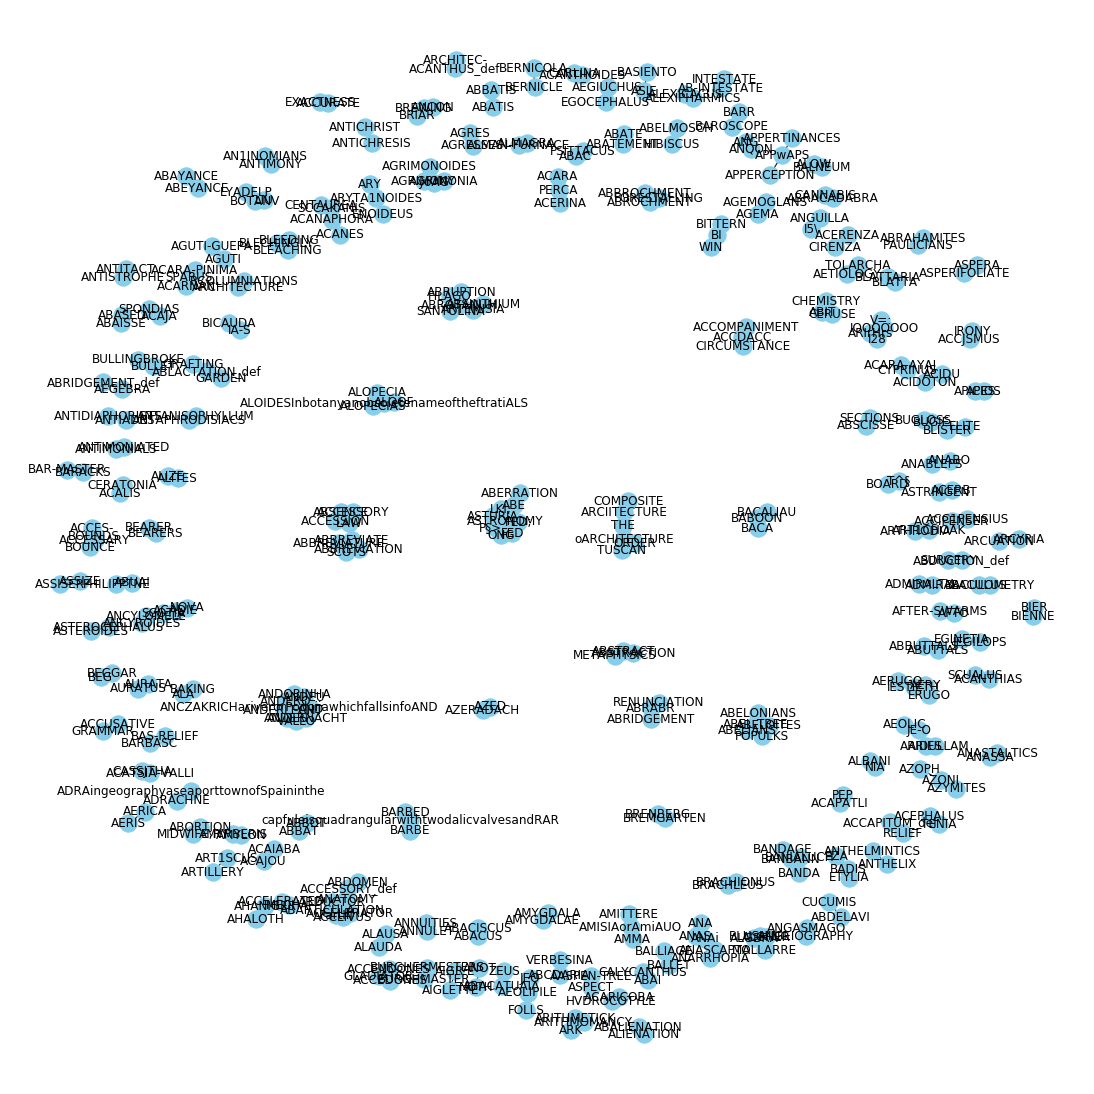

In [ ]:
plt.figure(figsize=(15,15))

pos = nx.spring_layout(graph_df)
nx.draw(graph_df, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()